## Preprocessing

In [1]:
# import the libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.image as mpimg

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Helper function

In [15]:
def visualize_cost (loss_train, acc_train, loss_val, acc_val):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(np.array(loss_val), '-o', label='val', linewidth=2)
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(np.array(acc_val), '-o', label='val', linewidth=2)
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [45]:
def visualize_cost2 (loss_train, acc_train, loss_val, acc_val, num_epochs):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,7))
    plt.grid()
    plt.subplot(1,2,1)

    plt.plot(range(1, num_epochs+1), np.array(loss_train), '-o', label='train', linewidth=2)
    plt.plot(range(1, num_epochs+1), np.array(loss_val), '-o', label='val', linewidth=2)

    plt.axvline(x=25, color='y',label = 'unfreeze net')
    plt.xlabel('$Epochs$', size=20)
    plt.ylabel('$Loss$', size=20)
    plt.legend(loc='best', fontsize=20)
    
    plot2 = plt.subplot(1,2,2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_train), '-o', label='train', linewidth=2)
    plot2.plot(range(1, num_epochs+1), np.array(acc_val), '-o', label='val', linewidth=2)
    plt.axvline(x=25, color='y',label = 'unfreeze net')
    plot2.set_xlabel('$Epochs$', size=20)
    plot2.set_ylabel('$Acc$', size=20)
    plot2.legend(loc='best', fontsize=20)
    plot2.grid(True)

    plt.show()

In [39]:
def show_specific(name, num, labels_map):

  values = list(labels_map.values())
  this_label = values.index(name)

  count = 0

  for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label.item() == this_label:
      image = image.unsqueeze(0)
      mini_batch = image
      count = 1
      break
  
  for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label.item() == this_label and count <= num:
      image = image.unsqueeze(0)
      mini_batch = torch.cat((mini_batch, image), dim=0)
      count+=1

  plt.figure(figsize=(10, 10))
  loader = DataLoader(dataset=mini_batch, batch_size=num, shuffle=True)
  images = next(iter(loader))
  images = torchvision.utils.make_grid(images)
  images = images.numpy().transpose(1,2,0)
  images = images*np.array(std) + np.array(mean)
  plt.axis('off')
  plt.title(name, size=50)
  plt.imshow(images)

In [16]:
class make_class_names(dict):

  def __init__(self):
    self = dict()

  def add(self, key, value):
    self[key] = value

In [17]:
def get_predictions(loader, model):

  model.eval()

  predicted_class = np.array([])
  targets = np.array([])

  with torch.no_grad():
    for idx, (images, labels) in enumerate(loader):

      labelsnp = labels.cpu().numpy()
      targets = np.concatenate((targets, labelsnp), axis=None)

      images = images.to(device) # torch.Size([3, 3, 224, 224]) train_dataset
      labels = labels.to(device) # torch.Size([3])

      y_predicted = model(images) # torch.Size([3, 5])
      _, index = torch.max(y_predicted, 1)

      convert = index.cpu().numpy()
      predicted_class = np.concatenate((predicted_class, convert), axis=None)

  return targets, predicted_class

In [18]:
def visualize_model(labels_map, num_rows, num_cols, dataset, mean, std, predicted_class):

  plt.figure(figsize=(10, 10))

  for i in range(num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1)
    index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[index]
    image = image.cpu().numpy().transpose(1,2,0)
    image = image * np.array(std) + np.array(mean)
    # image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label.item() == predicted_class[index]:
      check = 'green'
    else: check = 'red'
    plt.title(f'Pred: {labels_map[predicted_class[index]]}', color='white',
              backgroundcolor=check, fontsize=15)

  plt.show()

In [19]:
def predict(model, image_path, transform, labels_map, mean, std):

  image = Image.open(image_path).convert('RGB')
  image = transform(image)
  image = image.unsqueeze(0)
  image = image.to('cuda')

  model.eval()
  with torch.no_grad():

    y_predicted = model(image)
    _, index = torch.max(y_predicted, 1)

  pred = index.cpu().numpy()
  predicted_class = int(pred[0])

  img = mpimg.imread(image_path)
  plt.imshow(img)

  plt.title(f'Predicted: {labels_map[predicted_class]}', size=20)
  plt.axis('off')
  plt.show()

def predict_single(model, image_path):
  predict(model, image_path, visualize_trans, boys, mean, std)

In [20]:
def check_accuracy(loader, loader_dataset, model, labels_map):

  if loader == val_loader:
    print('Val Acc')
  elif loader == train_loader:
    print('Train Acc')
  else:
    print('Test Acc')

  running_corrects = 0
  num_samples = 0
  absent_class = []

  num_classes = len(list(labels_map.values()))

  n_correct_class = [0 for i in range(num_classes)]
  n_class_samples = [0 for i in range(num_classes)]

  model.eval()

  with torch.no_grad():

    for images, labels in loader:

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      running_corrects += (index == labels.data).sum()

      temp_ = index.cpu().numpy()
      num_samples += temp_.shape[0]

      temp = labels.cpu().numpy()

      for i in range(temp.shape[0]):
        
        label = temp[i]
        index_i = temp_[i]

        if label == index_i:
          n_correct_class[label] += 1
        n_class_samples[label] += 1

    convert = running_corrects.double()
    acc = convert / len(loader_dataset)
    print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

    for i in range(num_classes):
      if n_class_samples[i] != 0:
        acc_ = 100 * n_correct_class[i] / n_class_samples[i]
        print(f'Accuracy of {labels_map[i]}: {acc_:.2f}%')
      else:
        absent_class.append(i)
        print(f'Class {labels_map[i]} does not have its sample in this dataset.')

  return absent_class

In [55]:
def report_accuracy(targets, preds, labels_map, absent_class, num_classes):
  
  print(classification_report(targets, preds))
  cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
  index = np.random.randint(0, len(cmap_list))

  labels = list(labels_map.values())

  cm = confusion_matrix(targets, preds)
  if cm.shape[0] < num_classes:
    temp = np.zeros(num_classes-1)
    for item in absent_class:
      cm = np.insert(cm, item, temp, axis=0)
    temp = np.zeros(num_classes)
    for item in absent_class:
      cm = np.insert(cm, item, temp, axis=1)

  df_cm = pd.DataFrame(cm, labels, labels)
  sn.heatmap(df_cm, annot_kws={"size": 16}, annot=True, cmap=cmap_list[index], fmt = 'g')
  sn.set(font_scale=1.4)
  plt.title('Confusion Matrix')
  plt.ylabel('Correct-label', fontsize=20)
  plt.xlabel('Predicted-label', fontsize=20)
  plt.show()

In [22]:
def report(model, loader, loader_dataset, labels_map, targets, preds, num_classes):
  print("")
  absent = check_accuracy(loader, loader_dataset, model, labels_map)
  print("")
  report_accuracy(targets, preds, labels_map, absent, num_classes)

In [5]:
class BoysDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__ (self, index):

        image = self.annotations.iloc[index, 0]
        temp = image.split('.')
        folder_name = temp[0]
        folder_name = folder_name[:-3]                
        root_directory = os.path.join(self.root_dir, folder_name)

        image_path = os.path.join(root_directory, self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')
        y_label = torch.tensor(self.annotations.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [34]:
def save_checkpoint(state, is_best, filename='check_point.pth'):
  root_dir = '/content/drive/MyDrive/saved_ckpnt'
  if is_best:
    print('==> Saving new best')
    torch.save(state, os.path.join(root_dir, filename))
  else:
    print('==> Validation accuracy did not improve.')

## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


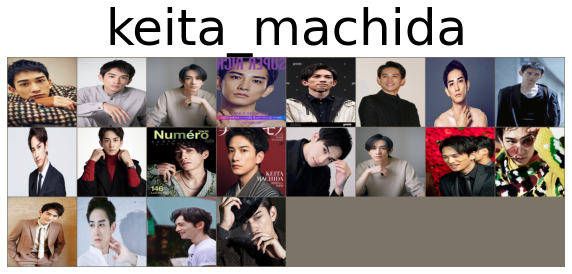

In [41]:
show_specific('keita_machida', 20, boys)

## Prepare the data

In [6]:
train_csv_file = '/content/drive/MyDrive/boys_train.csv'
val_csv_file = '/content/drive/MyDrive/boys_val.csv'

train_dir = '/content/drive/MyDrive/boys_dataset/train'
val_dir = '/content/drive/MyDrive/boys_dataset/val'

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [14]:
trans1 = transforms.Compose([
                             transforms.Resize((224, 224)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomAdjustSharpness(sharpness_factor=2),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

trans2 = transforms.Compose([
                             transforms.Resize((224, 224)),
                             transforms.RandomPosterize(bits=2),
                             transforms.RandomAutocontrast(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

visualize_trans = transforms.Compose([
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)
])

In [9]:
train_dataset = BoysDataset(csv_file = train_csv_file, root_dir = train_dir, transform = trans1)
val_dataset = BoysDataset(csv_file = val_csv_file, root_dir = val_dir, transform = trans2)
print(len(train_dataset))

100


In [10]:
val_size = int(len(val_dataset) * 0.8)
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(dataset=val_dataset, lengths=[val_size, test_size])
print(len(val_dataset), len(test_dataset))

60 15


In [13]:
boys = make_class_names()
i=0
for folder in os.listdir(val_dir):
  boys.add(i, folder)
  i+=1
print(boys)

{0: 'timmy_xu', 1: 'corbyn_besson', 2: 'keita_machida', 3: 'wang_kai', 4: 'chau_minh_chi'}


In [23]:
# Hyperparameter
num_epochs = 35
begin_epoch = 0
batch_size = 3
learning_rate = 0.001
load_model = True
load_model_file = '/content/drive/MyDrive/saved_ckpnt/ckpt_epch25_acc0.45.pth'
num_classes = 5

In [24]:
if load_model:
  loaded = torch.load(load_model_file)
  begin_epoch = loaded['epoch']
  best_acc = loaded['best_val_acc']
  print(f'Training resumes at epoch {begin_epoch}')
  print(f'Last best validation accuracy is {best_acc}')

Training resumes at epoch 25
Last best validation accuracy is 0.45000001788139343


In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Load the model

In [26]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [27]:
for param in model.parameters():
  param.requires_grad = True

In [28]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 5)

In [29]:
model = model.to(device)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [31]:
if load_model:
  loaded = torch.load(load_model_file)
  model.load_state_dict(loaded['model'])
  optimizer.load_state_dict(loaded['optimizer'])

In [32]:
model = model.to(device)

## Continued training

In [48]:
n_iters1 = math.ceil(len(train_dataset) / batch_size)
n_iters2 = math.ceil(len(val_dataset) / batch_size)

best_model_wts = copy.deepcopy(model.state_dict())
# best_acc = 0.0
begin_epoch = 35
num_epochs = 55
best_acc = loaded['best_val_acc']
start = time.time()

# step = 0
# step2 = 0

# if load_model:
#   loaded = torch.load(load_model_file)
#   loss_cache_train = loaded['loss']
#   acc_cache_train = loaded['acc']
#   loss_cache_val = loaded['loss_val']
#   acc_cache_val = loaded['acc_val']
#   best_acc = loaded['best_val_acc']
# else:
#   loss_cache_train = []
#   acc_cache_train = []
#   loss_cache_val = []
#   acc_cache_val = []

for epoch in range(begin_epoch, num_epochs):

  model.train()
  start_epoch = time.time()

  running_corrects = 0
  running_loss = 0.0

  for idx1, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)

    y_predicted = model(images)
    loss = criterion(y_predicted, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, index = torch.max(y_predicted, 1)
    running_corrects += torch.sum(index == labels)
    running_loss += loss.item() * images.size(0)

  epoch_loss = running_loss / len(train_dataset)
  epoch_acc = running_corrects / len(train_dataset)

  loss_cache_train.append(epoch_loss)
  acc_cache_train.append(epoch_acc.item())

  # writer_train.add_scalar('Epoch_loss', epoch_loss, global_step=step)
  # writer_train.add_scalar('Epoch_accuracy', epoch_acc, global_step=step)
  # step+=1
  
  model.eval()

  running_corrects = 0
  running_loss = 0.0

  for idx2, (images, labels) in enumerate(val_loader):
    
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      
      y_predicted = model(images)
      loss = criterion(y_predicted, labels)

      _, index = torch.max(y_predicted, 1)
      running_corrects += torch.sum(index == labels)
      running_loss += loss.item() * images.size(0)

  epoch_loss_val = running_loss / len(val_dataset)
  epoch_acc_val = running_corrects / len(val_dataset)

  loss_cache_val.append(epoch_loss_val)
  acc_cache_val.append(epoch_acc_val.item())

  # writer_val.add_scalar('Epoch_loss', epoch_loss_val, global_step=step2)
  # writer_val.add_scalar('Epoch_accuracy', epoch_acc_val, global_step=step2)
  # step2+=1

  is_best = bool(epoch_acc_val > best_acc)
  if is_best:
    best_acc = epoch_acc_val
    best_model_wts = copy.deepcopy(model.state_dict())
    num_epoch_trained = begin_epoch + epoch + 1
    checkpoint = {
            'epoch': num_epoch_trained,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': loss_cache_train,
            'acc': acc_cache_train,
            'loss_val': loss_cache_val,
            'acc_val': acc_cache_val,
            'best_val_acc': best_acc.item()
    }
    temp = best_acc.item()
    name = 'ckpt_epch' + str(num_epoch_trained) + '_acc' + str(round(temp, 5)) + '.pth'
    save_checkpoint(checkpoint, is_best, name)
  else:
    checkpoint = {}
    save_checkpoint(checkpoint, is_best, 'nothing')

  end_epoch = time.time()

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Step {idx1+1}/{n_iters1}, train Loss = {epoch_loss:.2f},  train Acc = {epoch_acc:.2f}')
  print(f'Step {idx2+1}/{n_iters2}, val loss = {epoch_loss_val:.2f},  val acc = {epoch_acc_val:.2f}')

  epoch_elapse = end_epoch - start_epoch
  print(f'Time spent for this epoch -----> {int(epoch_elapse // 60)}m {int(epoch_elapse % 60)}s')
  print("")

end = time.time()
duration = end - start
print(f'Training completes in {int(duration // 60)}m {int(duration % 60)}s')
print(f'Best val Acc: {best_acc:.4f}')
model.load_state_dict(best_model_wts)

==> Validation accuracy did not improve.
Epoch 36/55
Step 34/34, train Loss = 10.26,  train Acc = 0.17
Step 20/20, val loss = 1.77,  val acc = 0.18
Time spent for this epoch -----> 0m 11s

==> Validation accuracy did not improve.
Epoch 37/55
Step 34/34, train Loss = 5.62,  train Acc = 0.21
Step 20/20, val loss = 1.68,  val acc = 0.25
Time spent for this epoch -----> 0m 11s

==> Validation accuracy did not improve.
Epoch 38/55
Step 34/34, train Loss = 1.82,  train Acc = 0.18
Step 20/20, val loss = 1.75,  val acc = 0.18
Time spent for this epoch -----> 0m 11s

==> Validation accuracy did not improve.
Epoch 39/55
Step 34/34, train Loss = 1.73,  train Acc = 0.20
Step 20/20, val loss = 1.64,  val acc = 0.18
Time spent for this epoch -----> 0m 11s

==> Validation accuracy did not improve.
Epoch 40/55
Step 34/34, train Loss = 1.69,  train Acc = 0.22
Step 20/20, val loss = 1.64,  val acc = 0.25
Time spent for this epoch -----> 0m 11s

==> Validation accuracy did not improve.
Epoch 41/55
Step 3

<All keys matched successfully>

## Evaluation

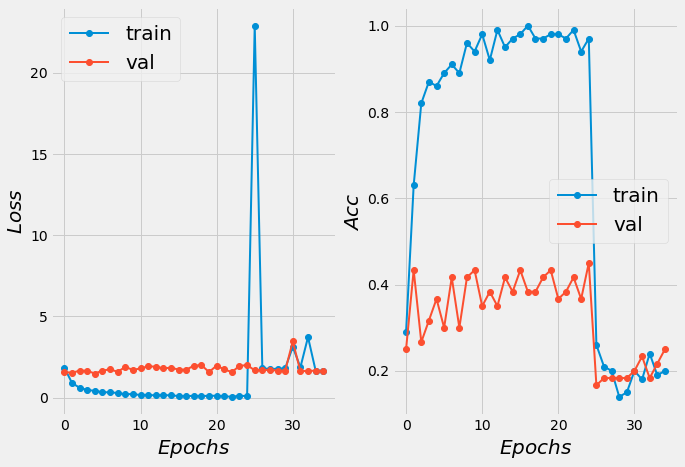

In [43]:
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val)

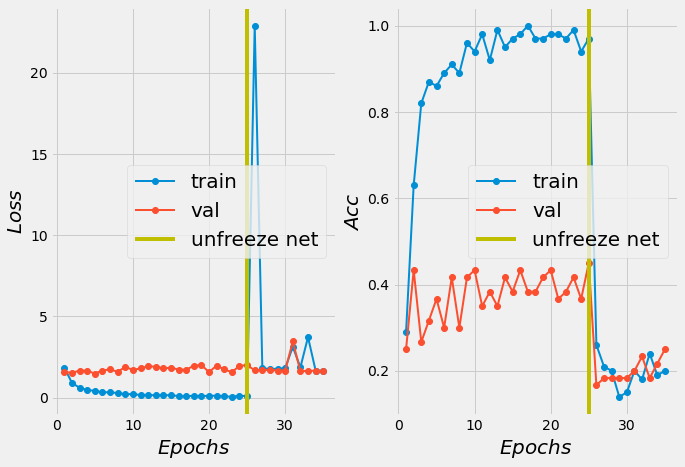

In [46]:
visualize_cost2(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val, num_epochs)

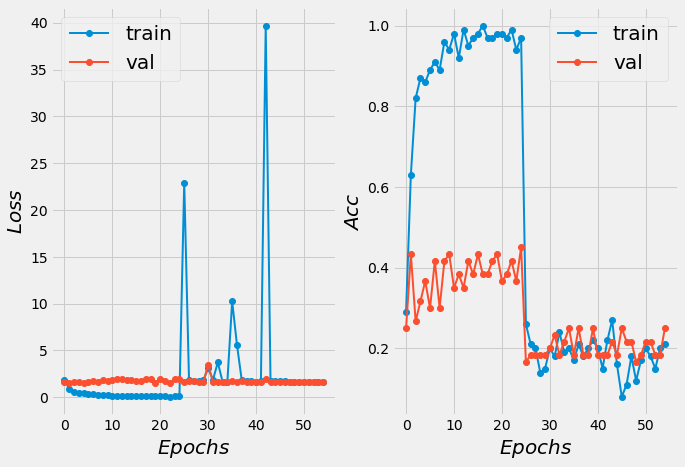

In [49]:
visualize_cost(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val)

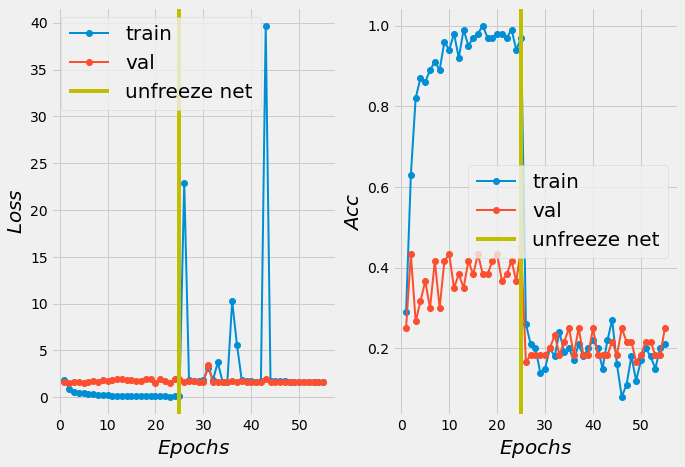

In [50]:
visualize_cost2(loss_cache_train, acc_cache_train, loss_cache_val, acc_cache_val, num_epochs)

In [51]:
targets, preds = get_predictions(test_loader, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


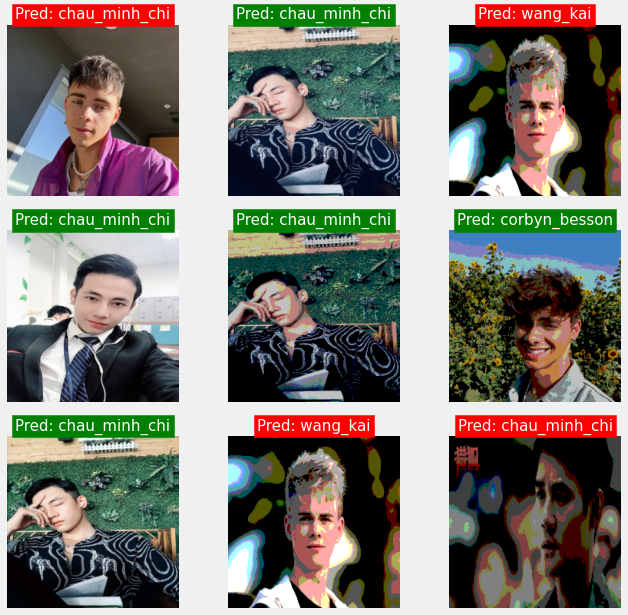

In [52]:
visualize_model(boys, 3, 3, test_dataset, mean, std, preds) # no of images displayed depends on the batch_size


Test Acc
Got 7/15 correct samples over 46.67%
Accuracy of timmy_xu: 50.00%
Accuracy of corbyn_besson: 50.00%
Class keita_machida does not have its sample in this dataset.
Accuracy of wang_kai: 25.00%
Accuracy of chau_minh_chi: 60.00%

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       1.00      0.25      0.40         4
         2.0       0.00      0.00      0.00         0
         3.0       0.50      0.25      0.33         4
         4.0       0.50      1.00      0.67         5

    accuracy                           0.47        15
   macro avg       0.40      0.30      0.28        15
weighted avg       0.57      0.47      0.42        15



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


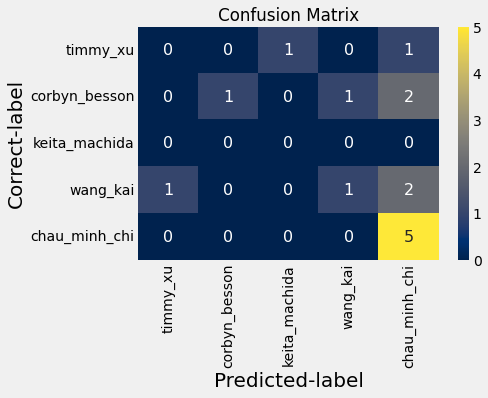

In [56]:
report(model, test_loader, test_dataset, boys, targets, preds, num_classes)

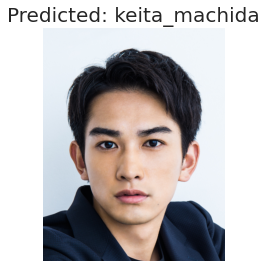

In [57]:
image_path = '/content/drive/MyDrive/predict_img/weoDY_5f.jpg'
predict_single(model, image_path)